# Low-Dimensional Representation Using Autoencoder

## Getting the Data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
# raw data location
data_path = 'visapy_data.npy'

In [6]:
visa = np.load(data_path).reshape((1200001,102))
print(visa.shape)

(1200001, 102)


In [7]:
print(visa)

[[  4 -18   3 ...   5 -11  -4]
 [  3 -26  -4 ...   6 -13   6]
 [  3 -25  -6 ...   5 -18   3]
 ...
 [  1  32  -5 ...   7   2   0]
 [-17  27  -9 ...  12  -1  11]
 [-13  21  -8 ...  15   0  10]]


In [8]:
# detection parameters
to_localize = False
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [9]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


## Detecting Spikes

In [10]:
H.DetectFromRaw()

# Sampling rate: 32000
# Localization Off
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 75

In [11]:
H.LoadDetected()

Detected and read 19341 spikes.


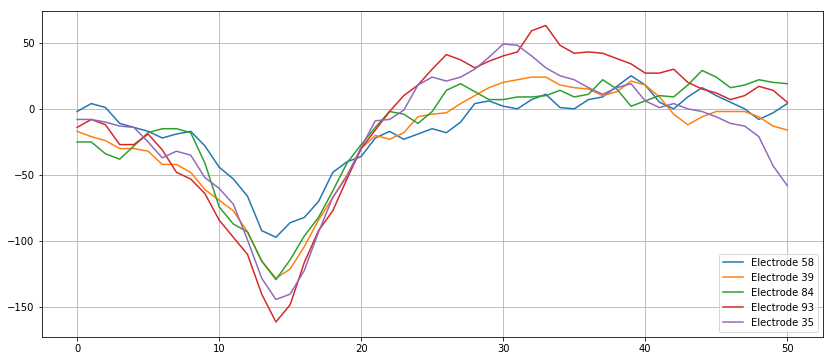

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14, 6))
for i in [14, 18, 77, 5, 156]:
    plt.plot(H.spikes['Shape'][i], label="Electrode "+str(H.spikes['ch'][i]))
plt.legend(loc=4)
plt.grid()
plt.show()
    

In [13]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]
embedding_size = (int)(length//4)

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(19341, 51)


In [16]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (15472, 51)
Test Datasize: (3869, 51)


In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(electrode_data_train)
e_data_pca = pca.transform(electrode_data_test)
e_data_proj = pca.inverse_transform(e_data_pca)

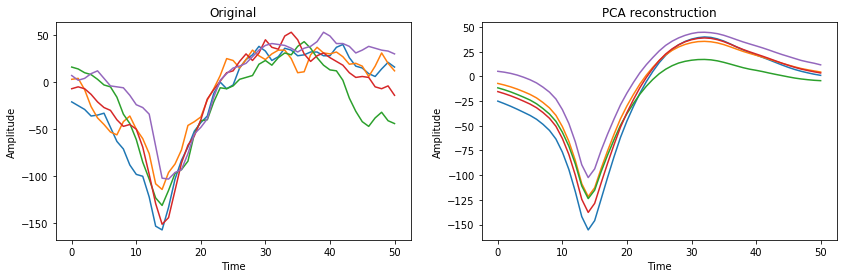

In [28]:
plt.figure(figsize=(14,4))

n = [3490, 1098, 2377, 9, 871]

for i in n:
    plt.subplot(121)
    plt.plot(electrode_data_test[i, :])
    plt.title('Original')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(122)
    plt.plot(e_data_proj[i, :])
    plt.title('PCA reconstruction')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.show()

## Scaling data between 0 and 1

In [94]:
# electrode_data = electrode_data_temp[:, :]

In [95]:
# max_val = np.amax(electrode_data)
# min_val = np.amin(electrode_data)
# span = max_val - min_val
# electrode_data = (electrode_data - min_val)/span

In [96]:
print(electrode_data)

[[ -7.  -2.   4. ...   7.   7.   9.]
 [ 35.  33.  26. ...   0.  -7. -10.]
 [ 15.  16.   8. ... -11.  -1.   1.]
 ...
 [ -2. -19. -23. ...  -7. -15. -31.]
 [ 12.   0.  -3. ...  -8. -10.  -5.]
 [-20. -32. -29. ...   9.   0.  -9.]]


## Designing the AutoEncoder 

In [97]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [98]:
class autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

## Splitting the data into Train and Test

In [99]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (15472, 51)
Test Datasize: (3869, 51)


In [100]:
random.seed(0)

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x)
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

In [101]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [102]:
epoch_range = 1000
batch_size = 150
learning_rate = 0.0001

ae_1 = autoencoder(length, embedding_size).cuda()
ae_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_1.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses = train_ae(ae_1, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/1000], loss:2696.60938, avg:2696.60938
epoch [2/1000], loss:814.14386, avg:1755.37659
epoch [3/1000], loss:359.83264, avg:1290.19531
epoch [4/1000], loss:91.81929, avg:990.60132
epoch [5/1000], loss:119.90456, avg:816.46198
epoch [6/1000], loss:70.90757, avg:692.20288
epoch [7/1000], loss:376.38910, avg:647.08667
epoch [8/1000], loss:156.40436, avg:585.75134
epoch [9/1000], loss:302.80026, avg:554.31232
epoch [10/1000], loss:583.59979, avg:557.24109
epoch [11/1000], loss:55.95045, avg:293.17520
epoch [12/1000], loss:181.54216, avg:229.91504
epoch [13/1000], loss:73.21373, avg:201.25313
epoch [14/1000], loss:47.89215, avg:196.86040
epoch [15/1000], loss:373.94431, avg:222.26439
epoch [16/1000], loss:247.13025, avg:239.88667
epoch [17/1000], loss:89.82492, avg:211.23022
epoch [18/1000], loss:351.12759, avg:230.70256
epoch [19/1000], loss:69.86075, avg:207.40862
epoch [20/1000], loss:81.79202, avg:157.22783
epoch [21/1000], loss:335.43103, avg:185.17589
epoch [22/1000], loss:49.9

epoch [180/1000], loss:30.37217, avg:40.77320
epoch [181/1000], loss:27.64705, avg:41.26963
epoch [182/1000], loss:51.22570, avg:41.50315
epoch [183/1000], loss:54.36275, avg:42.64886
epoch [184/1000], loss:35.15639, avg:40.00033
epoch [185/1000], loss:70.78148, avg:43.49968
epoch [186/1000], loss:155.31964, avg:55.47728
epoch [187/1000], loss:48.24220, avg:56.88478
epoch [188/1000], loss:33.99423, avg:54.18436
epoch [189/1000], loss:60.94137, avg:56.80430
epoch [190/1000], loss:37.26187, avg:57.49327
epoch [191/1000], loss:70.54962, avg:61.78353
epoch [192/1000], loss:38.03685, avg:60.46465
epoch [193/1000], loss:53.05456, avg:60.33383
epoch [194/1000], loss:30.18585, avg:59.83677
epoch [195/1000], loss:48.61544, avg:57.62016
epoch [196/1000], loss:45.59544, avg:46.64775
epoch [197/1000], loss:82.78248, avg:50.10177
epoch [198/1000], loss:53.47141, avg:52.04949
epoch [199/1000], loss:62.21800, avg:52.17715
epoch [200/1000], loss:75.98025, avg:56.04899
epoch [201/1000], loss:53.25534, 

epoch [359/1000], loss:43.50528, avg:34.06677
epoch [360/1000], loss:27.40664, avg:34.43447
epoch [361/1000], loss:31.90886, avg:35.14094
epoch [362/1000], loss:34.23763, avg:35.34898
epoch [363/1000], loss:26.34055, avg:34.17495
epoch [364/1000], loss:28.82308, avg:31.15774
epoch [365/1000], loss:34.24591, avg:31.92059
epoch [366/1000], loss:44.48229, avg:32.50608
epoch [367/1000], loss:85.20782, avg:38.65677
epoch [368/1000], loss:22.27472, avg:37.84328
epoch [369/1000], loss:49.39753, avg:38.43250
epoch [370/1000], loss:21.99598, avg:37.89143
epoch [371/1000], loss:21.69054, avg:36.86960
epoch [372/1000], loss:42.21710, avg:37.66755
epoch [373/1000], loss:25.42008, avg:37.57550
epoch [374/1000], loss:39.23081, avg:38.61628
epoch [375/1000], loss:48.33466, avg:40.02515
epoch [376/1000], loss:39.52853, avg:39.52978
epoch [377/1000], loss:39.37114, avg:34.94611
epoch [378/1000], loss:74.69743, avg:40.18838
epoch [379/1000], loss:50.08171, avg:40.25680
epoch [380/1000], loss:27.32032, a

epoch [538/1000], loss:30.51283, avg:34.61929
epoch [539/1000], loss:26.73801, avg:34.57855
epoch [540/1000], loss:40.52413, avg:34.67517
epoch [541/1000], loss:52.94738, avg:36.18084
epoch [542/1000], loss:51.31412, avg:38.98721
epoch [543/1000], loss:58.75481, avg:42.73457
epoch [544/1000], loss:37.47222, avg:39.20555
epoch [545/1000], loss:31.81076, avg:39.19935
epoch [546/1000], loss:29.49980, avg:40.29004
epoch [547/1000], loss:31.72086, avg:39.12949
epoch [548/1000], loss:52.02752, avg:41.28096
epoch [549/1000], loss:43.37822, avg:42.94498
epoch [550/1000], loss:62.95803, avg:45.18837
epoch [551/1000], loss:53.16006, avg:45.20964
epoch [552/1000], loss:90.83398, avg:49.16163
epoch [553/1000], loss:35.84064, avg:46.87021
epoch [554/1000], loss:52.29148, avg:48.35213
epoch [555/1000], loss:40.01760, avg:49.17282
epoch [556/1000], loss:43.78710, avg:50.60155
epoch [557/1000], loss:49.85608, avg:52.41508
epoch [558/1000], loss:41.09628, avg:51.32195
epoch [559/1000], loss:87.17284, a

epoch [717/1000], loss:23.71117, avg:43.55882
epoch [718/1000], loss:26.24952, avg:42.48815
epoch [719/1000], loss:19.29515, avg:36.54552
epoch [720/1000], loss:15.49203, avg:34.19830
epoch [721/1000], loss:32.41243, avg:35.04182
epoch [722/1000], loss:25.19002, avg:33.93089
epoch [723/1000], loss:41.96333, avg:30.07471
epoch [724/1000], loss:41.23629, avg:29.09312
epoch [725/1000], loss:20.15888, avg:28.23500
epoch [726/1000], loss:30.85926, avg:27.65681
epoch [727/1000], loss:33.72813, avg:28.65850
epoch [728/1000], loss:39.81716, avg:30.01526
epoch [729/1000], loss:53.39326, avg:33.42508
epoch [730/1000], loss:37.87633, avg:35.66351
epoch [731/1000], loss:27.61314, avg:35.18358
epoch [732/1000], loss:45.77225, avg:37.24181
epoch [733/1000], loss:17.70071, avg:34.81554
epoch [734/1000], loss:31.46008, avg:33.83792
epoch [735/1000], loss:33.52443, avg:35.17448
epoch [736/1000], loss:38.56190, avg:35.94474
epoch [737/1000], loss:46.84148, avg:37.25607
epoch [738/1000], loss:11.25904, a

epoch [896/1000], loss:24.73779, avg:35.86804
epoch [897/1000], loss:17.48289, avg:33.37187
epoch [898/1000], loss:28.23438, avg:32.81414
epoch [899/1000], loss:23.68900, avg:32.14965
epoch [900/1000], loss:25.54395, avg:27.24740
epoch [901/1000], loss:92.27337, avg:33.03403
epoch [902/1000], loss:65.49770, avg:36.63318
epoch [903/1000], loss:35.75303, avg:36.49041
epoch [904/1000], loss:24.19227, avg:36.68573
epoch [905/1000], loss:28.90088, avg:36.63052
epoch [906/1000], loss:42.67758, avg:38.42450
epoch [907/1000], loss:21.76142, avg:38.85236
epoch [908/1000], loss:26.73048, avg:38.70197
epoch [909/1000], loss:14.92080, avg:37.82515
epoch [910/1000], loss:21.72572, avg:37.44332
epoch [911/1000], loss:34.13742, avg:31.62973
epoch [912/1000], loss:44.90856, avg:29.57082
epoch [913/1000], loss:27.44491, avg:28.74001
epoch [914/1000], loss:23.62370, avg:28.68315
epoch [915/1000], loss:16.49580, avg:27.44264
epoch [916/1000], loss:24.22811, avg:25.59769
epoch [917/1000], loss:28.19476, a

## Loss Plot and Reconstruction

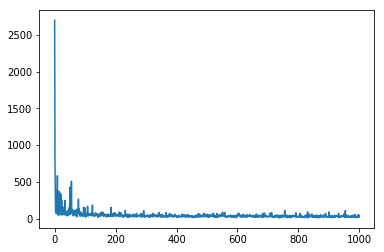

In [103]:
plt.figure()
plt.plot(losses)
plt.show()

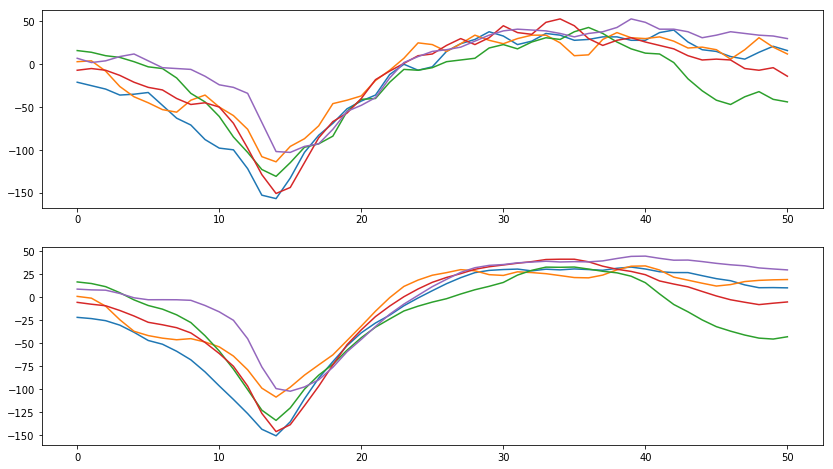

In [104]:
plt.figure(figsize=(14,8))

# n = [1, 30, 45, 50, 65]
n = [3490, 1098, 2377, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    plt.subplot(211)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(212)
    plt.plot(o)
plt.show()

In [105]:
torch.save(ae_1, 'models/visapy/ae_01072018.pt') #Saving the autoencoder model

## Using GANs for super-resolution

### Designing the GAN

In [106]:
class generator(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(generator, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [107]:
class discriminator(nn.Module):
    def __init__(self, input_size):
        super(discriminator, self).__init__()
        self.detect = nn.Sequential(nn.Linear(input_size, 32),
                                    nn.ELU(),
                                    nn.Linear(32, 16),
                                    nn.ELU(),
                                    nn.Linear(16, 4),
                                    nn.ELU(),
                                    nn.Linear(4, 1),
                                    nn.Sigmoid())
    def forward(self, x):
        out = self.detect(x)
        return out

In [108]:
# Using Trick 4 - Diffferent mini-batches of real and fake data for training

random.seed(0)

def train_gan(disc, gen, input_data, d_criterion, g_criterion, d_optimizer, g_optimizer, epoch_range,  
              batch_size_d, batch_size_g):
    for num_epoch in range(epoch_range):
        
        d_selected = random.sample(range(0, input_data.shape[0]), batch_size_d)

        for feats in d_selected:
            #---------Training the discriminator on real data------#
            real_data = input_data[feats, :]
            real_data = torch.from_numpy(real_data).float().cuda()
            #---------FORWARD------------#
            real_decision = disc.forward(real_data)
            real_decision = torch.tensor(real_decision).float().cuda()
            real_loss = d_criterion(real_decision, Variable(torch.ones(1)).cuda())
            #---------BACKWARD------------#
            real_loss.backward()
            
            d_optimizer.zero_grad()            
            d_optimizer.step()
        
        d_selected = random.sample(range(0, input_data.shape[0]), batch_size_d)
        
        for feats in d_selected:
            
            #---------Training the discriminator on fake data------#
            enc, fake_data = gen.forward(real_data)
            fake_data = torch.tensor(fake_data).float().cuda()
            #---------FORWARD------------#
            fake_decision = disc.forward(fake_data)
            fake_decision = torch.tensor(fake_decision).float().cuda()
            fake_loss = d_criterion(fake_decision, Variable(torch.zeros(1)).cuda())
            #---------BACKWARD------------#
            fake_loss.backward()
            
            d_optimizer.zero_grad()            
            d_optimizer.step()
        
        g_selected = random.sample(range(0, input_data.shape[0]), batch_size_g)
        
        for feats in g_selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = gen.forward(x)
            out = torch.tensor(out).float().cuda()
            g_loss = g_criterion(out, x)
            #---------BACKWARD------------#
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
        print('epoch [{}/{}], disc_real_loss:{:.4f}, disc_fake_loss:{:.4f}, gen_loss:{:.4f}'.format(num_epoch + 1, 
                                                    epoch_range, real_loss.data[0], fake_loss.data[0], g_loss.data[0]))
    return out

In [109]:
def init_gan_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [110]:
epoch_range = 500
batch_size_d = 150
batch_size_g = 100
g_learning_rate = 0.0001
d_learning_rate = 0.0001

# Defining the models
gen = generator(length, embedding_size).cuda()
disc = discriminator(length).cuda()

# Initialising the weights
gen.apply(init_gan_weights)
disc.apply(init_gan_weights)

# Setting up the loss criteria
g_criterion = nn.MSELoss()
d_criterion = nn.BCELoss()

# Setting up the Optimizer (Using Adam here)
g_optimizer = torch.optim.Adam(
    gen.parameters(), lr=g_learning_rate, weight_decay=0.001)
d_optimizer = torch.optim.Adam(
    disc.parameters(), lr=d_learning_rate, weight_decay=0.001)

out = train_gan(disc, gen, electrode_data_train, d_criterion, g_criterion, 
                             d_optimizer, g_optimizer, epoch_range, batch_size_d, batch_size_g)

epoch [1/500], disc_real_loss:27.6310, disc_fake_loss:0.3612, gen_loss:2619.2620
epoch [2/500], disc_real_loss:18.3074, disc_fake_loss:0.0000, gen_loss:1740.1268
epoch [3/500], disc_real_loss:10.6993, disc_fake_loss:0.0008, gen_loss:712.4047
epoch [4/500], disc_real_loss:23.4599, disc_fake_loss:0.0000, gen_loss:142.1964
epoch [5/500], disc_real_loss:16.5262, disc_fake_loss:0.0000, gen_loss:175.3190
epoch [6/500], disc_real_loss:3.1796, disc_fake_loss:0.0029, gen_loss:260.5960
epoch [7/500], disc_real_loss:4.1443, disc_fake_loss:0.0047, gen_loss:187.6189
epoch [8/500], disc_real_loss:10.0922, disc_fake_loss:0.0073, gen_loss:90.4738
epoch [9/500], disc_real_loss:2.6618, disc_fake_loss:0.1072, gen_loss:75.6567
epoch [10/500], disc_real_loss:0.6231, disc_fake_loss:0.2196, gen_loss:142.6722
epoch [11/500], disc_real_loss:2.2165, disc_fake_loss:0.2913, gen_loss:59.7447
epoch [12/500], disc_real_loss:0.8932, disc_fake_loss:0.3043, gen_loss:184.4031
epoch [13/500], disc_real_loss:1.1404, disc_

epoch [105/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:56.6819
epoch [106/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:39.2293
epoch [107/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:88.0651
epoch [108/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:70.4796
epoch [109/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:193.5874
epoch [110/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:72.6194
epoch [111/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:52.5155
epoch [112/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:33.8008
epoch [113/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:57.1360
epoch [114/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:259.5716
epoch [115/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:49.2924
epoch [116/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:175.6429
epoch [117/500], disc_real_loss:0.693

epoch [208/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:91.9663
epoch [209/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:32.5573
epoch [210/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:45.1735
epoch [211/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:27.5516
epoch [212/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.6182
epoch [213/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:50.1526
epoch [214/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:35.9046
epoch [215/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:71.5360
epoch [216/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:55.1701
epoch [217/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:24.0677
epoch [218/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:52.9253
epoch [219/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:63.1227
epoch [220/500], disc_real_loss:0.6931, 

epoch [311/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:33.5396
epoch [312/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:40.3302
epoch [313/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:41.0283
epoch [314/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:63.3932
epoch [315/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:25.6648
epoch [316/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:53.0204
epoch [317/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:43.6631
epoch [318/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:47.3638
epoch [319/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:49.9205
epoch [320/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:33.1876
epoch [321/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:43.1278
epoch [322/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:37.2877
epoch [323/500], disc_real_loss:0.6931, 

epoch [414/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:24.8066
epoch [415/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:39.1589
epoch [416/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:64.7613
epoch [417/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:46.3144
epoch [418/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:41.9619
epoch [419/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:46.2363
epoch [420/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:50.6900
epoch [421/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:34.0377
epoch [422/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:66.4896
epoch [423/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:58.8849
epoch [424/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:44.3570
epoch [425/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:33.0458
epoch [426/500], disc_real_loss:0.6931, 

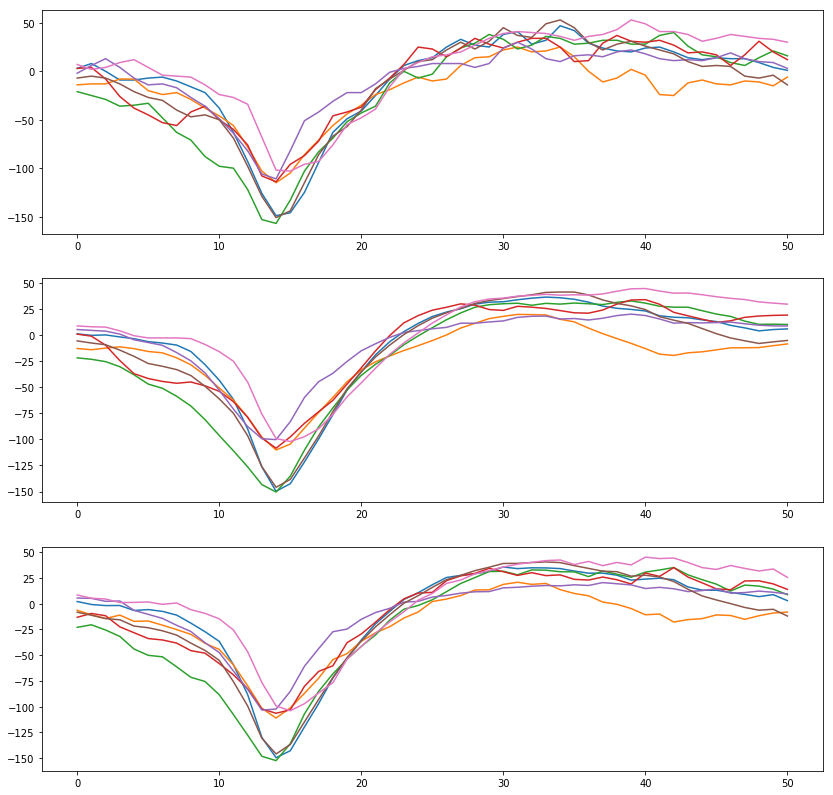

In [111]:
plt.figure(figsize=(14,14))

# n = [1, 30, 45, 50, 65]
n = [11, 290, 3490, 1098, 2707, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    #print(np.sum(np.subtract(electrode_data_test[i, :], o)))
    enc, o_gan = gen.forward(data)
    o_gan = (o_gan.data).cpu().numpy()
    #print(np.sum(np.subtract(electrode_data_test[i, :], o_gan)))
    #print('-----------------')
    plt.subplot(311)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(312)
    plt.plot(o)
    plt.subplot(313)
    plt.plot(o_gan)
plt.show()

In [112]:
torch.save(gen, 'models/visapy/gan_01072018.pt') #Saving the autoencoder model

## Designing LSTM-Autoencoders

In [113]:
class lstm_autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(lstm_autoencoder, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.LSTM(input_size=input_size, hidden_size=75, num_layers=2, bidirectional=True),
                                     activation_layer,
                                     nn.LSTM(input_size=75, hidden_size=28, num_layers=2, bidirectional=True),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.LSTM(input_size=embedding_size, hidden_size=16, num_layers=2, bidirectional=True),
                                     activation_layer,
                                     nn.LSTM(input_size=16, hidden_size=25, num_layers=2, bidirectional=True),
                                     activation_layer,
                                     nn.Linear(25, input_size))    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [114]:
random.seed(0)

def train_lstm(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x)
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

In [115]:
def init_lstm_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.LSTM:
        nn.init.xavier_normal_(layer.weight)

In [116]:
epoch_range = 1000
batch_size = 150
learning_rate = 0.0001

lstm_ae = autoencoder(length, embedding_size).cuda()
lstm_ae.apply(init_lstm_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses = train_lstm(lstm_ae, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/1000], loss:2350.78247, avg:2350.78247
epoch [2/1000], loss:713.69189, avg:1532.23718
epoch [3/1000], loss:352.36118, avg:1138.94519
epoch [4/1000], loss:92.36629, avg:877.30042
epoch [5/1000], loss:118.60840, avg:725.56201
epoch [6/1000], loss:68.31532, avg:616.02094
epoch [7/1000], loss:359.40536, avg:579.36157
epoch [8/1000], loss:142.46004, avg:524.74884
epoch [9/1000], loss:261.37164, avg:495.48471
epoch [10/1000], loss:465.37256, avg:492.47348
epoch [11/1000], loss:51.76136, avg:262.57144
epoch [12/1000], loss:132.83258, avg:204.48547
epoch [13/1000], loss:84.05250, avg:177.65462
epoch [14/1000], loss:52.56728, avg:173.67470
epoch [15/1000], loss:355.86084, avg:197.39995
epoch [16/1000], loss:180.57626, avg:208.62605
epoch [17/1000], loss:85.76281, avg:181.26178
epoch [18/1000], loss:197.85222, avg:186.80101
epoch [19/1000], loss:59.74808, avg:166.63864
epoch [20/1000], loss:64.52382, avg:126.55376
epoch [21/1000], loss:159.05948, avg:137.28357
epoch [22/1000], loss:36.2

epoch [180/1000], loss:31.59790, avg:42.71878
epoch [181/1000], loss:34.07547, avg:43.13364
epoch [182/1000], loss:49.25464, avg:42.55456
epoch [183/1000], loss:52.78726, avg:43.77927
epoch [184/1000], loss:35.06336, avg:40.45187
epoch [185/1000], loss:83.26934, avg:45.38009
epoch [186/1000], loss:156.64677, avg:57.91379
epoch [187/1000], loss:41.47512, avg:57.56750
epoch [188/1000], loss:32.06698, avg:55.36880
epoch [189/1000], loss:52.04081, avg:56.82777
epoch [190/1000], loss:43.70581, avg:58.03856
epoch [191/1000], loss:73.64639, avg:61.99564
epoch [192/1000], loss:40.92141, avg:61.16232
epoch [193/1000], loss:65.41995, avg:62.42560
epoch [194/1000], loss:32.88620, avg:62.20789
epoch [195/1000], loss:62.41868, avg:60.12281
epoch [196/1000], loss:51.39876, avg:49.59801
epoch [197/1000], loss:76.35284, avg:53.08578
epoch [198/1000], loss:47.62096, avg:54.64118
epoch [199/1000], loss:40.21445, avg:53.45855
epoch [200/1000], loss:63.95239, avg:55.48320
epoch [201/1000], loss:51.13476, 

epoch [359/1000], loss:43.34686, avg:38.75077
epoch [360/1000], loss:27.29712, avg:39.19272
epoch [361/1000], loss:30.70458, avg:37.15692
epoch [362/1000], loss:31.54976, avg:37.06541
epoch [363/1000], loss:33.79747, avg:35.33960
epoch [364/1000], loss:29.77903, avg:31.24613
epoch [365/1000], loss:41.74826, avg:33.30893
epoch [366/1000], loss:41.79226, avg:33.58888
epoch [367/1000], loss:89.09666, avg:40.52939
epoch [368/1000], loss:18.21929, avg:38.73313
epoch [369/1000], loss:38.44748, avg:38.24319
epoch [370/1000], loss:19.89158, avg:37.50264
epoch [371/1000], loss:21.17557, avg:36.54974
epoch [372/1000], loss:43.47610, avg:37.74237
epoch [373/1000], loss:24.50395, avg:36.81301
epoch [374/1000], loss:30.85219, avg:36.92033
epoch [375/1000], loss:55.43728, avg:38.28924
epoch [376/1000], loss:38.99615, avg:38.00962
epoch [377/1000], loss:34.60265, avg:32.56023
epoch [378/1000], loss:53.61122, avg:36.09942
epoch [379/1000], loss:68.45858, avg:39.10053
epoch [380/1000], loss:27.05786, a

epoch [538/1000], loss:27.62048, avg:31.05668
epoch [539/1000], loss:26.61995, avg:31.29230
epoch [540/1000], loss:44.49478, avg:32.02218
epoch [541/1000], loss:57.26125, avg:34.21335
epoch [542/1000], loss:41.12733, avg:35.77711
epoch [543/1000], loss:49.37056, avg:38.01483
epoch [544/1000], loss:42.18224, avg:37.35531
epoch [545/1000], loss:36.21097, avg:37.88108
epoch [546/1000], loss:44.55371, avg:40.53063
epoch [547/1000], loss:34.34698, avg:40.37883
epoch [548/1000], loss:46.32855, avg:42.24963
epoch [549/1000], loss:43.59240, avg:43.94688
epoch [550/1000], loss:76.83941, avg:47.18134
epoch [551/1000], loss:42.56414, avg:45.71163
epoch [552/1000], loss:58.61152, avg:47.46005
epoch [553/1000], loss:34.41611, avg:45.96460
epoch [554/1000], loss:53.71499, avg:47.11788
epoch [555/1000], loss:48.97533, avg:48.39431
epoch [556/1000], loss:20.90183, avg:46.02913
epoch [557/1000], loss:36.63119, avg:46.25755
epoch [558/1000], loss:39.15440, avg:45.54013
epoch [559/1000], loss:55.00353, a

epoch [717/1000], loss:21.58761, avg:33.48286
epoch [718/1000], loss:18.45882, avg:33.68346
epoch [719/1000], loss:29.59578, avg:30.37906
epoch [720/1000], loss:17.68345, avg:28.63710
epoch [721/1000], loss:26.73217, avg:29.19288
epoch [722/1000], loss:17.60346, avg:27.95955
epoch [723/1000], loss:44.81653, avg:28.19615
epoch [724/1000], loss:43.80827, avg:28.15822
epoch [725/1000], loss:31.09677, avg:28.97020
epoch [726/1000], loss:35.01494, avg:28.63978
epoch [727/1000], loss:29.09397, avg:29.39042
epoch [728/1000], loss:33.83360, avg:30.92789
epoch [729/1000], loss:41.30725, avg:32.09904
epoch [730/1000], loss:31.65827, avg:33.49652
epoch [731/1000], loss:34.77799, avg:34.30111
epoch [732/1000], loss:50.04872, avg:37.54563
epoch [733/1000], loss:17.49335, avg:34.81331
epoch [734/1000], loss:31.99216, avg:33.63170
epoch [735/1000], loss:24.28489, avg:32.95051
epoch [736/1000], loss:29.82516, avg:32.43154
epoch [737/1000], loss:34.95661, avg:33.01780
epoch [738/1000], loss:11.74867, a

epoch [896/1000], loss:20.36476, avg:28.18788
epoch [897/1000], loss:13.56273, avg:26.52309
epoch [898/1000], loss:44.75090, avg:27.26413
epoch [899/1000], loss:36.07225, avg:28.55742
epoch [900/1000], loss:21.78104, avg:26.09084
epoch [901/1000], loss:104.27872, avg:34.14334
epoch [902/1000], loss:44.15804, avg:35.14337
epoch [903/1000], loss:24.96387, avg:35.80250
epoch [904/1000], loss:26.37170, avg:36.26890
epoch [905/1000], loss:30.39661, avg:36.67006
epoch [906/1000], loss:33.33049, avg:37.96664
epoch [907/1000], loss:19.07928, avg:38.51829
epoch [908/1000], loss:23.97740, avg:36.44094
epoch [909/1000], loss:10.45493, avg:33.87921
epoch [910/1000], loss:19.36575, avg:33.63768
epoch [911/1000], loss:27.39568, avg:25.94938
epoch [912/1000], loss:44.80584, avg:26.01416
epoch [913/1000], loss:30.12103, avg:26.52987
epoch [914/1000], loss:26.26507, avg:26.51921
epoch [915/1000], loss:15.27735, avg:25.00728
epoch [916/1000], loss:23.26236, avg:24.00047
epoch [917/1000], loss:19.18129, 

21.07939399778843
1.8365687727928162
-8.224904641509056
-----------------
20.00569587945938
-8.974041640758514
-12.044389486312866
-----------------
15.722004532814026
13.46980094909668
-1.3428474068641663
-----------------
9.100877106189728
7.690576553344727
-2.0802440643310547
-----------------
7.9914103746414185
6.0994508266448975
-9.427704825997353
-----------------
21.896392464637756
-0.15909993648529053
-17.21386231482029
-----------------
7.185061395168304
13.140422880649567
31.25422179698944
-----------------


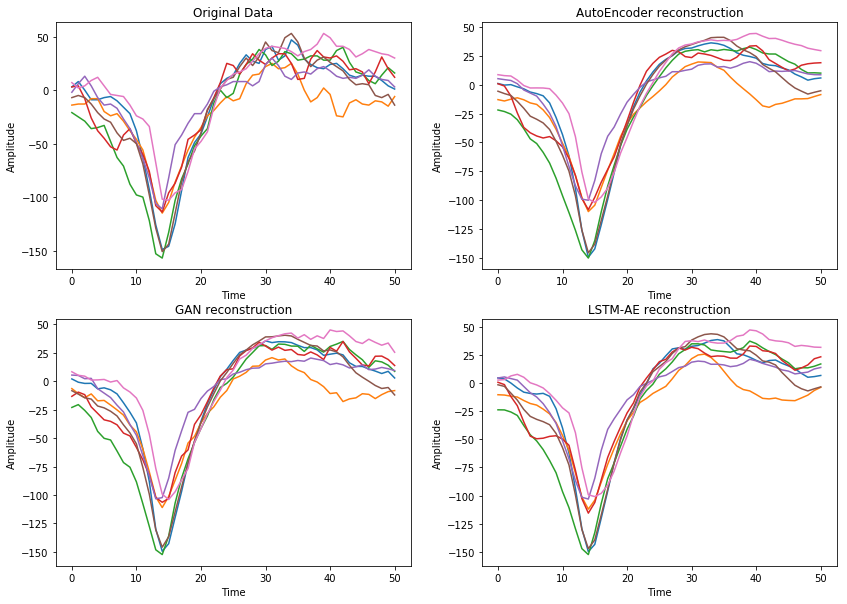

In [120]:
plt.figure(figsize=(14,10))

# n = [1, 30, 45, 50, 65]
n = [11, 290, 3490, 1098, 2707, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o)))
    enc, o_gan = gen.forward(data)
    o_gan = (o_gan.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_gan)))
    enc, o_lstm = lstm_ae.forward(data)
    o_lstm = (o_lstm.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_lstm)))
    print('-----------------')
    plt.subplot(221)
    plt.plot(electrode_data_test[i, :])
    plt.title('Original Data')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(222)
    plt.plot(o)
    plt.title('AutoEncoder reconstruction')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(223)
    plt.plot(o_gan)
    plt.title('GAN reconstruction')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(224)
    plt.plot(o_lstm)
    plt.title('LSTM-AE reconstruction')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.show()

## Listing all output embeddings for t-SNE

In [76]:
from sklearn import (manifold, datasets, decomposition, ensemble, 
                     discriminant_analysis, random_projection)
from sklearn.cluster import MeanShift, estimate_bandwidth

### Encoding all data points

In [42]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [73]:
encoded_data_ae = np.zeros((electrode_data.shape[0], embedding_size))
encoded_data_gan = np.zeros((electrode_data.shape[0], embedding_size))
encoded_data_lstm = np.zeros((electrode_data.shape[0], embedding_size))


for i in range(electrode_data.shape[0]):
    temp = electrode_data[i, :]
    temp = torch.from_numpy(temp).float().cuda()
    
    encoded, o = ae_1.forward(temp)
    encoded = (encoded.data).cpu().numpy()
    encoded_data_ae[i, :] = encoded[:]
    
    #print("Completed "+str(i+1)+" iterations.")

#tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
print('stage1')
#ae_pca = decomposition.TruncatedSVD(n_components=3).fit_transform(encoded_data_ae)
#ae_tsne = tsne.fit_transform(encoded_data_ae)
print('stage2')


stage1
stage2


In [82]:
ae_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(encoded_data_ae)
bandwidth = estimate_bandwidth(ae_pca, quantile=0.2, n_samples=40000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(encoded_data_ae)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

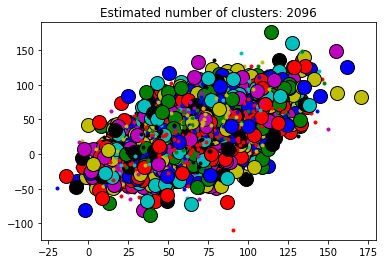

In [83]:
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(encoded_data_ae[my_members, 0], encoded_data_ae[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()